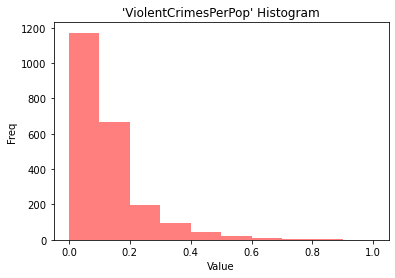

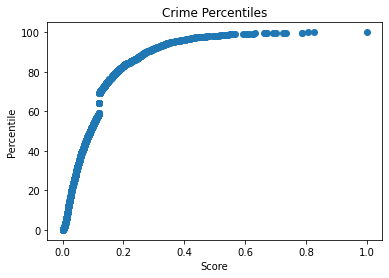

(1549, 101)
(332, 101)
(333, 101)


In [18]:
%run alt_Preprocessing.ipynb

In [22]:
# Import packages
import sklearn.feature_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import GridSearchCV # RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns

In [19]:
# Split the data into training and test data sets using sklearn.model_selection
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.70, random_state=1)

# check the dataset to see how much the dataset has grown (if dimenstionality was increased)
print(data.shape)
print(x.shape)

(2214, 144)
(2214, 103)


In [3]:
y

0       0
1       0
2       0
3       1
4       0
       ..
2209    0
2210    0
2211    0
2212    0
2213    1
Name: ViolentCrimesPerPop, Length: 2214, dtype: int64

**Feature Selection**
- Build the model using the pre-processed data

In order to avoid overfitting and slow computing (due to the increase in features from dummying as well as increasing dimensionality), selecting the most important features is important. 


In [20]:
# select k best is a univariate method for feature selection:
# looks at the outcome and the relationship with each feature and selects k number of best features 
select = sklearn.feature_selection.SelectKBest(k=20)
selected_features = select.fit(x_train, y_train)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [x.columns[I] for I in indices_selected]

x_train_selected = x_train[colnames_selected]
x_test_selected = x_test[colnames_selected]

colnames_selected # 20 features selected


['racepctblack',
 'racePctWhite',
 'pctWInvInc',
 'pctWPubAsst',
 'PctPopUnderPov',
 'PctNotHSGrad',
 'PctUnemployed',
 'MalePctDivorce',
 'FemalePctDiv',
 'TotalPctDiv',
 'PctFam2Par',
 'PctKids2Par',
 'PctYoungKids2Par',
 'PctTeen2Par',
 'PctKidsBornNeverMar',
 'PctLargHouseFam',
 'PctPersOwnOccup',
 'PctPersDenseHous',
 'PctVacantBoarded',
 'PctHousNoPhone']

**Build Decision tree #1**

Accuracy: 0.724812030075188


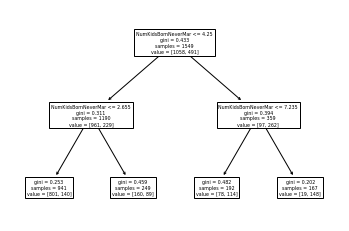

In [23]:
# Plot tree at depth 2
dtree = DecisionTreeClassifier(criterion='gini', max_depth=2)  # use the entropy rather than gini index
dtree = dtree.fit(x_train, y_train)
tree.plot_tree(dtree, feature_names=data.columns) 

# model can then be used to predict !
# crime_predict = dtree.predict([[0,1]])

# Assess accuracy at this stage
clf = DecisionTreeClassifier()  # Create Decision Tree classifer object
clf = clf.fit(x_train,y_train)  # Train Decision Tree Classifer
y_pred = clf.predict(x_test)  # Predict the response for test dataset
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [24]:
# Applying Kfold Stratified
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=10)
folds

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [25]:
scores = []

def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

for train_index, test_index in folds.split(x, y):
    X_train, X_test, y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]
    print(get_score(DecisionTreeClassifier(), X_train, X_test, y_train, y_test))

KeyError: "None of [Int64Index([ 203,  204,  205,  212,  218,  221,  222,  223,  227,  231,\n            ...\n            2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213],\n           dtype='int64', length=1992)] are in the [columns]"

In [6]:
# most stylised tree:
# import graphviz
# dot_data = tree.export_graphviz(dtree, out_file=None, feature_names=features, filled=True, rounded=True, special_characters=True)
# graph = graphviz.Source(dot_data)
# graph

**Build the Decision tree #2** - applying pre-pruning techniques

In [26]:
# Testing pre pruning

params = {'max_depth': [2,4,6,8,10,12],  # why did we select these parameters?
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2]}

clf = DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv = gcv.fit(x_train,y_train)
y_pred = gcv.predict(x_test)  # Predict the response for test dataset
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) # better accuracy score

Accuracy: 0.7308270676691729


Train score 0.8340865074241446
Test score 0.7308270676691729
Train Confusion matrix


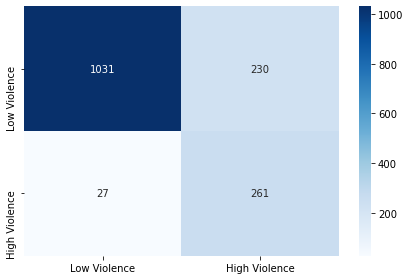

Test Confusion matrix


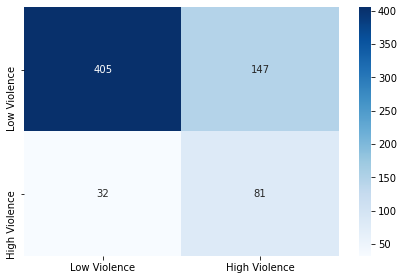

In [27]:
# Pre-pruning summary

classes = ['Low Violence', 'High Violence']
def plot_confusionmatrix(train_pred, train, dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(train_pred,train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()
    
model = gcv.best_estimator_
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

**Build Decision Tree #3** - applying post-pruning techniques

https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py

Total impurity of leaves vs effective alphas of pruned tree:

Minimal cost complexity pruning recursively finds the node with the “weakest link”. The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first.

Scikit-learn provides DecisionTreeClassifier.cost_complexity_pruning_path that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

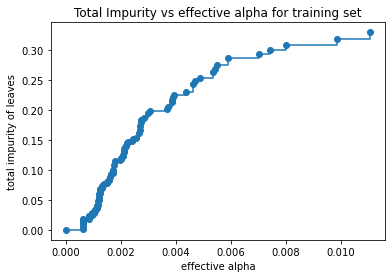

In [28]:
# 1. Cost complexity pruning path
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
# Plot
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
# the maximum effective alpha value is removed, because it is the trivial tree with only one node.


In [29]:
# 2. Train a decision tree using the effective alphas.
# The last value in ccp_alphas is the alpha value that prunes the whole tree, 
# this leaves the tree (clfs[-1]) with one node.

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.1028282003523327


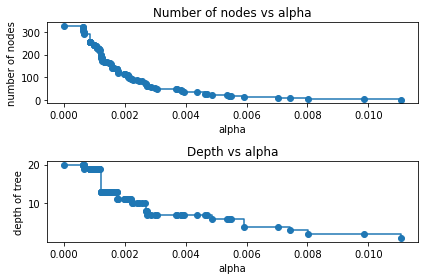

In [15]:
# 3. Remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node.
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

# Show that the number of nodes and tree depth decreases as alpha increases.
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

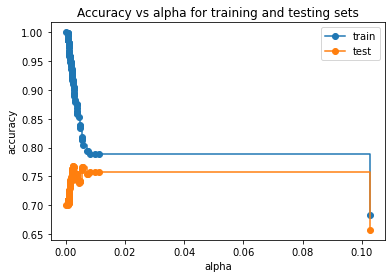

In [32]:
# 4. Compare accuracy vs alpha for training
# When ccp_alpha is set to zero, the tree overfits; leading to a 100% training accuracy and 88% testing accuracy.
# As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better. 

train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [33]:
# fit the model again with the most suitable alpha i.e. 0.008
# this alpha achieves the best test accuracy

tree = DecisionTreeClassifier(ccp_alpha=0.01, random_state=40)
tree.fit(x_train, y_train)
y_train_pred=tree.predict(x_train)
y_test_pred=tree.predict(x_test)

print("Pruned tree train accuracy score: ", accuracy_score(y_train, y_train_pred),
"Pruned tree test accuracy score: ", accuracy_score(y_test, y_test_pred))

Pruned tree train accuracy score:  0.789541639767592 Pruned tree test accuracy score:  0.7578947368421053


In [14]:
# extra graphs needed 
# https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html
    